<a href="https://colab.research.google.com/github/LukrecijaTudor/NLP/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U sentence-transformers

In [ ]:
#pip install tokenizers

In [ ]:
pip install umap-learn

In [ ]:
pip install pycld2

In [ ]:
pip install pyLDAvis

In [ ]:
#pip install simpletransformers

In [ ]:
import sys

In [ ]:
#pip install textprocessingutil_py

In [ ]:
#from textprocessingutil_py import TextUtil
#textUtil = TextUtil()
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from sklearn.cluster import KMeans

import torch
import umap
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim import models
import gensim.corpora as corpora
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from gensim.matutils import softcossim
import math
import nltk
lemma = nltk.wordnet.WordNetLemmatizer()
#python -m pip install -U pycld2
import pycld2 as cld2
import spacy
sp = spacy.load("en")
sp_stopwords=sp.Defaults.stop_words
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import DistilBertModel, DistilBertConfig
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
#from simpletransformers.classification import ClassificationModel

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from google.colab import files
import io
import collections

In [ ]:
acronyms = pd.read_excel("/content/kratice.xlsx")
acronyms = acronyms.rename(columns={'kratice':'acronym','Unnamed: 1':'replacement'})

In [ ]:
def acronyms_to_words (txt):
    #acronyms = pd.read_excel("/Users/Lukre/Desktop/D/kratice.xlsx")
    #acronyms = acronyms.rename(columns={'kratice':'acronym','Unnamed: 1':'replacement'})
    for i in range (len(acronyms)):
        txt=txt.replace(' ' + acronyms.acronym[i] + ' ',' ' + acronyms.replacement[i] + ' ')
    return txt

def isNaN(string):
    return string != string

In [ ]:
document = pd.read_csv("/content/qa06_all.csv")
document = document.rename(columns={'qa06id': 'id', 'qa06name':'title', 'qa06wher':'location','qa06dsc':'report'})
document_risk=pd.read_csv("/content/qa06_only_having_risk_valuesl.csv")
document_risk = document_risk.rename(columns={'qa06id': 'id', 'qa06name':'title', 'qa06wher':'location','qa06dsc':'report','ty26colo':'label','ty26fakt':'factor'})

In [ ]:
doc_risk_str=pd.read_csv("/content/doc_risk_str.csv")
doc_risk_tok=pd.read_csv("/content/doc_risk_tok.csv")

In [ ]:
# train/validation split
def train_val_split_1 (doc,label,rnd=42,size=0.2):
  X_train, X_val, y_train, y_val = train_test_split(doc.index.values, 
                                                  doc.label.values, 
                                                  test_size=size, 
                                                  random_state=rnd, 
                                                  stratify=doc.label.values)
  doc['data_type'] = ['not_set']*doc.shape[0]


  doc.loc[X_train, 'data_type'] = 'train'
  doc.loc[X_val, 'data_type'] = 'val' 
  return doc

def train_val_split_2 (doc,doc2,label,rnd=42,size=0.2):
  X_train, X_val, y_train, y_val = train_test_split(doc.index.values, 
                                                  doc.label.values, 
                                                  test_size=size, 
                                                  random_state=rnd, 
                                                  stratify=doc.label.values)
  doc['data_type'] = ['not_set']*doc.shape[0]
  doc2['data_type'] = ['not_set']*doc2.shape[0]


  doc.loc[X_train, 'data_type'] = 'train'
  doc.loc[X_val, 'data_type'] = 'val' 
  doc2.loc[X_train, 'data_type'] = 'train'
  doc2.loc[X_val, 'data_type'] = 'val'

  return doc,doc2

Bert

In [ ]:
def prep_doc_bert(document):
    
  doc = pd.DataFrame(columns=['report'])
    
  for i in range(len(document)):
       
      if isNaN(document.report[i]):
          continue
      isReliable, textBytesFound, details=cld2.detect(document.report[i])
      
      if not isReliable:
                  continue
      if details[0][0]!='ENGLISH':
          continue
      
      txt=acronyms_to_words (document.report[i])
      doc=doc.append({'report': txt},ignore_index=True)
  return doc

In [ ]:
%%time
doc_bert=prep_doc_bert(document)

CPU times: user 12.1 s, sys: 2.06 ms, total: 12.1 s
Wall time: 12.1 s


In [ ]:
num_of_topics = 3
#num_of_topics = 4
#num_of_topics = 5
#num_of_topics = 6

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

100%|██████████| 245M/245M [00:13<00:00, 18.6MB/s]


In [ ]:
print(model.get_max_seq_length())
model.max_seq_length = 512
print(model.get_max_seq_length())

128
512


In [ ]:
type(list(doc_bert.report))

list

In [ ]:
embeddings = model.encode(doc_bert.report, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
embeddings_vec= np.array(embeddings)

In [ ]:
embeddings_vec.shape

(3358, 768)

LDA

In [ ]:
doc_no_risk_tok = pd.read_csv("/content/doc_no_risk_tok.csv")
doc_lda=[txt.split() for txt in doc_no_risk_tok.report]

In [ ]:
id2word = corpora.Dictionary(doc_lda)
corpus = [id2word.doc2bow(text) for text in doc_lda]
tfidf_model = models.TfidfModel(corpus)
tfidf_corpus=[tfidf_model[text] for text in corpus]

In [ ]:
tfidf_corpus
print(embeddings_vec)

[[ 0.30562615  0.23621218  0.43556255 ...  0.29496714  0.62751436
  -0.00754754]
 [-0.7205443   0.04740383  0.6475415  ...  0.18191497 -0.02332224
  -0.14723326]
 [ 0.9370104   0.3256255   0.9854007  ...  0.27092984 -0.31653997
   0.79834664]
 ...
 [-0.05597919 -0.01685948  1.0711968  ... -0.09011391  0.21681225
  -0.26363635]
 [ 0.2531593  -0.21130592  1.0195907  ... -0.23946472  0.40824407
  -0.19727124]
 [ 0.16316736 -0.16641758  0.7211894  ... -0.11973397 -0.04199033
  -0.49836016]]


In [ ]:
num_of_topics = 3
#num_of_topics = 4
#num_of_topics = 5
#num_of_topics = 6

corpus_lda=tfidf_corpus
#corpus_lda=embeddings_vec
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_lda,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [ ]:
#LDA vector representation 

def get_lda_vec(model, corpus, k):
  n_doc = len(corpus)
  lda_vec = np.zeros((n_doc, k))
  for i in range(n_doc):
      for topic, prob in model.get_document_topics(corpus[i]):
          lda_vec[i, topic] = prob

  return lda_vec


In [ ]:
lda_vec = get_lda_vec(lda_model, corpus_lda, num_of_topics)

In [ ]:
lda_gamma = 1000  # parameter for reletive importance of lda

lda_bert_vec = np.c_[lda_vec * lda_gamma, embeddings_vec]

**K-means**

In [ ]:
#k_means = KMeans(n_clusters=num_of_topics)
#k_means.fit(embeddings_vec)
#k_means.fit(lda_vec)
k_means.fit(lda_bert_vec)
clusters = k_means.labels_

# Create list of all sentences in the cluster
#clustered_sentences = [[] for i in range(num_of_topics)]
#for sentence_id, cluster_id in enumerate(clusters):
#    clustered_sentences[cluster_id].append(doc_bert[sentence_id])

GRAPH REPRESENTATION

In [ ]:
%%time
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_vec)
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(lda_vec)
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(lda_bert_vec)

CPU times: user 30.2 s, sys: 190 ms, total: 30.3 s
Wall time: 23 s


In [ ]:
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = k_means.labels_
#tempResult = result
#tempResult['labels'].unique()

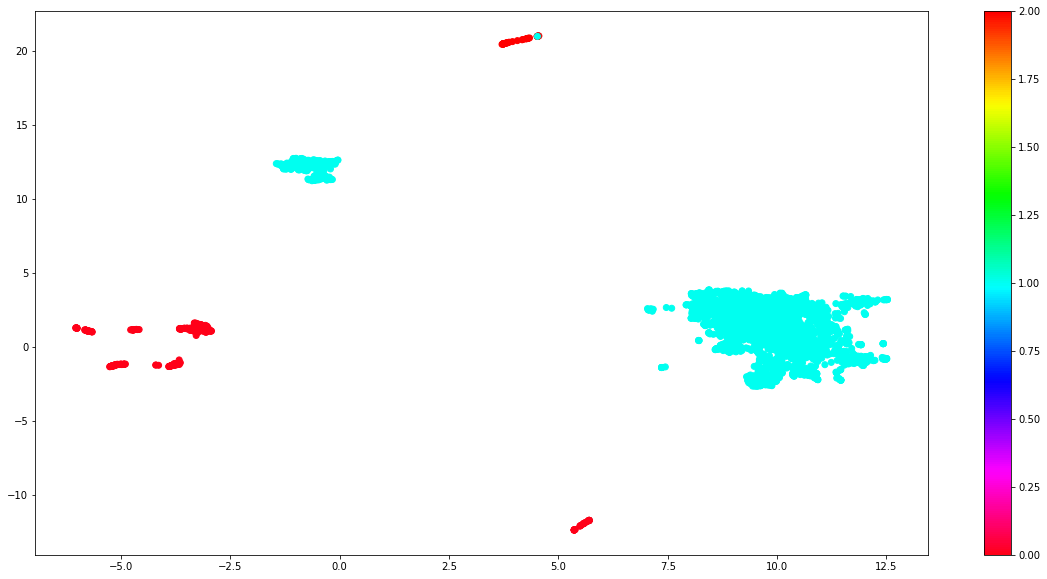

In [ ]:
# Plot reduced vector to check how number of clousters  works
fig, ax = plt.subplots(figsize=(20, 10))
clustered = result.loc[result.labels > -1, :]
#clustered = result.loc[result.labels != -1, :]
#clustered[:50]
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
# male tocke s=0.05 plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

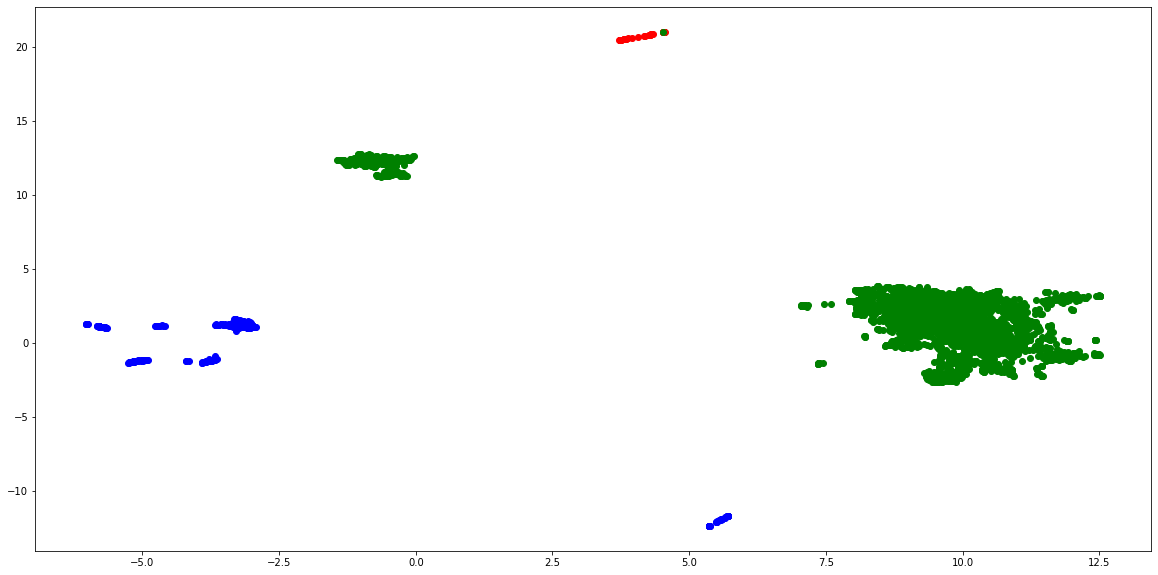

In [ ]:
# My version for Plot reduced vector to check how number of clousters  works
fig, ax = plt.subplots(figsize=(20, 10))

colors={0:'b',1:'g',2:'r',3:'c', 4:'m', 5: 'y', 6: 'k'}

resultArray = result.to_numpy()
for i in resultArray:
    x= i[0]
    y= i[1]
    l= i[2]
    #if  l==0 or l==1 or l== 2 orl==3:
    plt.scatter(x, y, color=colors[l] )


In [ ]:
collections.Counter(k_means.labels_)

Counter({0: 358, 1: 2953, 2: 47})

In [ ]:
k_means_silhouette = silhouette_score(lda_bert_vec, k_means.labels_).round(2)
#k_means_silhouette = silhouette_score(embeddings_vec, k_means.labels_).round(2)
#k_means_silhouette = silhouette_score(lda_vec, k_means.labels_).round(2)
k_means_silhouette

0.97

Najbolji rezultat:
num_of_topic = 3, lda_gamma=60, silhouette=0.69
num_of_topic = 4, lda_gamma=100, silhouette=0.23

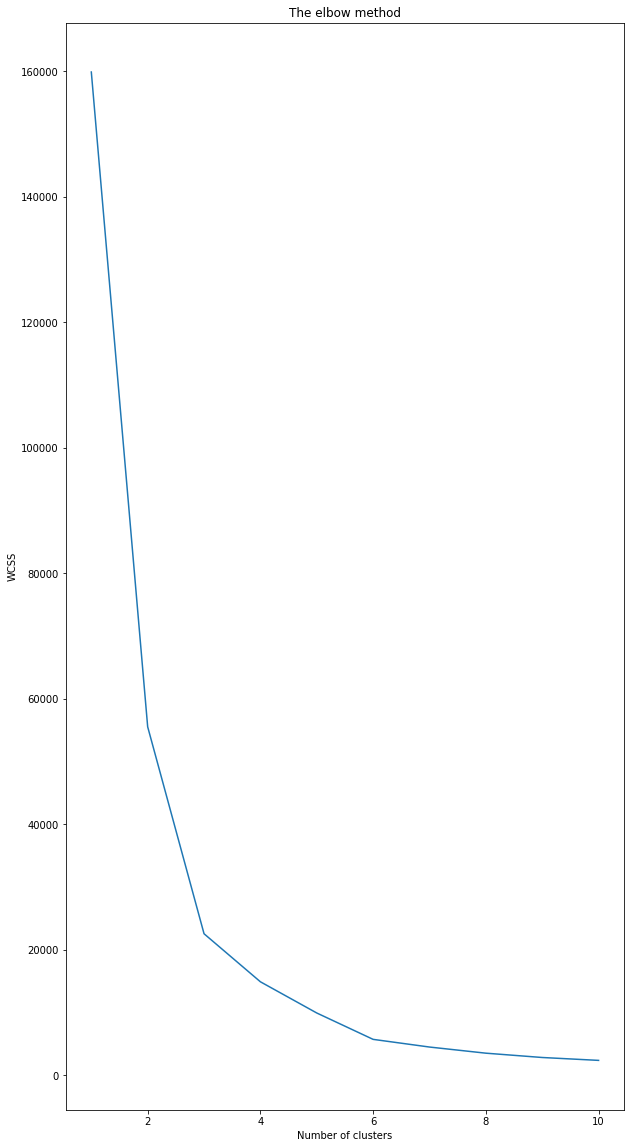

[159892.86, 55548.41609379338, 22570.648858618668, 14914.857631894552, 9942.936821384352, 5739.980606580124, 4517.23995607335, 3539.2545868450575, 2851.5288525417163, 2391.27241089232]


In [ ]:
x=umap_data
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.rcParams["figure.figsize"] = (10,20)
plt.show()
print (wcss)

Rezultati:

 num_of_topics = 3, gamma=100, lda_bert_vec **0.86**, elbow = **3**

num_of_topics = 3, lda_vec **0.98**, elbow = **4,5,prije 5 nego 4**

num_of_topics = 3, bert_vec **0.00**, elbow = **3**